# Projet :  Classification chats et chiens

##### Lantrade morgan & Couderc-Lafont Enguerran

### Table of Contents

* [A) MLP : Multi-Layer Perceptron](#chapter1)
    * Fonctions et Dérivées
        * activations
        * coûts
    * Forme de nos données
    * Initialisation des poids et des biais
    * Forward propagation
    * Backward propagation
    * Apprentissage
    * Visualisation de l'apprentissage
    
   
* [B) Prétraitement des données](#chapter2)
    * Chargement des données
    * Visualisation des photos
    * Applatissement des images
    * Normalisation
    * Test avec un perceptron
        * MSE
        * log_loss
             
* [C) Réduction du nombre de variables par ACP](#chapter3)
    * Standardiser nos données
    * Déterminer la matrice de corrélation
    * Trouver les valeurs propres et les vecteurs propres
    * Classer les valeurs propres par ordre décroissant
    * Analyse :
        * Inerties
        * Eboulies
    * Conserver les k premiers vecteur propres
    * Projection de nos données par la matrice de passage
    * Visualisation :
        * Photos modifiées ( oeil )
        * Hyperplan
    
   
* [D) Optimisation du modèle sur nos données réduites](#chapter4)
    * Optimisation des hyper-paramètres avec scikit-learn
    * Interprétation des résultats
    * Tests des modèles avec sklearn
    * Tests des modèles avec notre implémentation MLP      

* [Conclusion](#chapter5)



#### Importations

In [1]:
!pip install h5py
from utilities import *
import sklearn
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

# A) MLP : Multi-Layer Perceptron à L couches <a class="anchor" id="chapter1"></a>

### Fonctions
#### Activations

In [2]:
def sigmoide(Z):
    return 1/(1+np.exp(-Z))

def d_sigmoide(A):
    return A*(1-A)

def relu(Z):
    return np.where(Z>0,Z,0)

def d_relu(A):
    return np.where(A>0,1,0)


ACTIVATIONS={'logistic' : (sigmoide,d_sigmoide),'relu': (relu,d_relu)}


#### Coûts

$$\begin{alignat}{2} L_{MSE}=& \frac{1}{m}.\sum_{k=1}^{m} (y_k-a_k)^2\\
L_{log\_loss}=& -\frac{1}{m}.\sum_{k=1}^{m} y_{k}.ln(a_{k})+(1-y_k).ln(1-a_k)\\
\end{alignat}$$

$$\begin{alignat}{2} 
\frac{\partial L_{MSE}}{\partial a_k}=& \frac{2}{m}.\sum_{k=1}^{m} (a_k-y_k)\\
\frac{\partial L_{log\_loss}}{\partial a_k} =& \frac{1}{m}.\sum_{k=1}^m \frac{a_k-y_k}{a_k(1-a_k)})\\
\end{alignat}$$

In [41]:
def MSE(A,y):
    m=y.shape[1]
    return 1/m*np.sum((y-A)**2)

def log_loss(A,y,eps=10**(-15)):  #eps car log n'est pas définie en 0
    m=y.shape[1]
    return - 1/m* np.sum(y *np.log(A+eps) + (1 - y) * np.log(1-A+eps))

def d_MSE(A,y):
    '''Retourne la dérivée de la fonction cout * la dérivée de la sigmoide
       Correspond au dL/dZ de notre modèle
       La somme de 1 à m sera faite en produit matriciel avec une activation(m,n)'''
    m=y.shape[1]
    return 2/m*(A-y)*A*(1-A)

def d_log_loss(A,y):
    '''Retourne la dérivée de la fonction cout * la dérivée de la sigmoide
       Correspond au dL/dZ de notre modèle
       La somme de 1 à m sera faite en produit matriciel avec une activation(m,n)'''
    m=y.shape[1]
    #on a simplifié la fraction voir plus tard
    return 1/m*(A-y) 

COSTS={ 'log_loss':(log_loss,d_log_loss),'MSE': (MSE,d_MSE)}


### Formes des données

- m échantillons 
- $n^{[l-1]}$ variables  en entrée 
- $n^{[l]}$ en sortie 

$$\begin{alignat}{2} A^{[0]}= {}^TX = & \underbrace{\begin{bmatrix}
x_{1,1} & x_{1,2}&...& x_{1,m}\\
... &  ...&   ...&   ...&\\
x_{n^{[0]},1} & x_{n^{[0]},2}&...& x_{n^{[0]},m}\\
\end{bmatrix}}_{(n^{[0]},m)}\\
Y = & \underbrace{\begin{bmatrix}
y_{1} & y_{2} &... &y_{m}\end{bmatrix}}_{(1,m)}\\
W^{[l]} = & \underbrace{\begin{bmatrix}w^{[l]}_{1,1} & w^{[l]}_{1,2} &... &w^{[l]}_{1,n^{[l-1]}}\\
... & ... &... &... \\
w^{[l]}_{n^{[l]},1} & w^{[l]}_{n^{[l]},2} &... &w^{[l]}_{n^{[l]},n^{[l-1]}}\\
\end{bmatrix}}_{(n^{[l]},n^{[l-1]})} & B^{[l]}= \underbrace{\begin{bmatrix}
b^{[l]}_{1}\\
...\\
b^{[l]}_{n^{[l]}}\end{bmatrix}}_{(n^{[l]},1)}
\end{alignat}$$

###  Initialisation des poids

In [43]:
def initW(n_input,n_output):
    '''Initialisation de W pour une couche'''
    W= np.random.randn(n_output,n_input)
    b=np.random.randn(n_output,1)
    return W,b

def initWeights(X,y,hidden_layers,random_state=None):
    '''Initialisation des poids de toutes les couches'''
    
    #pour éviter des initialisations différentes sur les mêmes données et modèles différents
    if random_state:
        np.random.seed(random_state)
    #initialisation
    layers_size=[X.shape[1]]+hidden_layers+[y.shape[1]]
    weights,biais=[],[]
    #parcours des couches
    for i in range(len(layers_size)-1):
        W,b=initW(layers_size[i],layers_size[i+1])
        weights.append(W)
        biais.append(b)
    return weights,biais

#simulation X,y
X=np.ones((1000,4096)) #m=200 
y=np.ones((1000,1))

print("Pour une couche et un neurone:")
weights0,biais0=initWeights(X,y,[])
for w,b in zip(weights0,biais0):
    print(w.shape,b.shape)

print("Pour 3 couches cachées 32x64x22 :")
weights1,biais1=initWeights(X,y,[32,64,22])
for w,b in zip(weights1,biais1):
    print(w.shape,b.shape)
    
    

Pour une couche et un neurone:
(1, 4096) (1, 1)
Pour 3 couches cachées 32x64x22 :
(32, 4096) (32, 1)
(64, 32) (64, 1)
(22, 64) (22, 1)
(1, 22) (1, 1)


###  Forward propagation 

$$
\forall l \in \{1,...,L\} : couches\\
\forall j \in \{1,...,n^{[L]}\} : neurones\\
\forall k \in \{1,...,m\} : échantillons
$$ 

$$\begin{alignat}{2} z^{[l]}_{jk} = & \sum_{i=1}^{n^{[l-1]}} w^{[l]}_{ji}.a^{[l-1]}_{ik} + b_j^{[l]}\\
\newline
\underbrace{Z}_{(n^{[l]},m)}^{[l]}  = & \begin{bmatrix}
\sum_{i=1}^{n^{[l-1]}} \color{red}w^{[l]}_{1,i}.\color{green}a^{[l-1]}_{i,1} + \color{blue}b_1^{[l]} &, &\sum_{i=1}^{n^{[l-1]}} \color{red}w^{[l]}_{1,i}.\color{green}a^{[l-1]}_{i,2} + \color{blue}b_1^{[l]} &, &... &, &\sum_{i=1}^{n^{[l-1]}} \color{red}w^{[l]}_{1,i}.\color{green}a^{[l-1]}_{im} + \color{blue}b_1^{[l]}\\
... &,  &... &, &... &,  & ...\\
\sum_{i=1}^{n^{[l-1]}} \color{red}w^{[l]}_{n^{[l]},i}.\color{green}a^{[l-1]}_{i,1} + \color{blue}b^{[l]}_{n^{[l]}} &, &\sum_{i=1}^{n^{[l-1]}}\color{red}w^{[l]}_{n^{[l]},i}.\color{green}a^{[l-1]}_{i,2} + \color{blue}b^{[l]}_{n^{[l]}} &, &... &, &\sum_{i=1}^{n^{[l-1]}} \color{red}w^{[l]}_{n^{[l]},i}.\color{green}a^{[l-1]}_{i,m} + \color{blue}b^{[l]}_{n^{[l]}}\\
\end{bmatrix}\\
\newline
\underbrace{Z}_{(n^{[l]},m)}^{[l]} = &\color{red}{\underbrace{{\begin{bmatrix}w^{[l]}_{1,1} & w^{[l]}_{1,2} &{...} &w^{[l]}_{1,n^{[l-1]}}\\
... & ... &... &... \\
w^{[l]}_{n^{[l]},1} & w^{[l]}_{n^{[l]},2} &{...} &w^{[l]}_{n^{[l]},n^{[l-1]}} \\
\end{bmatrix}}}_{(n^{[l]},n^{[l-1]})}}.\color{green}{\underbrace{\begin{bmatrix}
a^{[l-1]}_{1,1} & a^{[l-1]}_{1,2}&...& a^{[l-1]}_{1,m}\\
... &  ...&   ...&   ...&\\
a^{[l-1]}_{n^{[l-1]},1} & a^{[l-1]}_{n^{[l-1]},2}&...& a^{[l-1]}_{n^{[l-1]},m}\\
\end{bmatrix}}_{(n^{[l-1]},m)}}+\color{blue}{\underbrace{\begin{bmatrix}
b^{[l]}_1& ...& b^{[l]}_1\\
{...}& ...& ...\\
b^{[l]}_{n^{[l]}}& ...& b^{[l]}_{n^{[l]}} \end{bmatrix}}_{(n^{[l]},m)}}\\
\underbrace{Z}_{(n^{[l]},m)}^{[l]} = & W^{[l]}.A^{[l-1]} + B^{[l]} \\
\newline
\underbrace{A}^{[l]}_{(n^{[l]},m)}= &\frac{1}{1+e^{-Z^{[l]}}}
\end{alignat}$$

<div class="alert alert-block alert-success">
On obtient les activations où les lignes correspondent aux neurones et colonnes aux échantillons.</div>


<div class="alert alert-block alert-info">
<b>Remarque 1:</b> Le produit matriciel nous permet de faire la somme de 1 a m pour obtenir la matrice Z.
    
<b>Remarque 2:</b> On peut réduire B à une seule colonne car numpy permet d'additionner toute une ligne selon une valeur (broadcast).</div>

In [44]:
 def forward(X,weights,biais,f='logistic'):
        '''Retourne une liste des activations 
        A[0]=X.T '''
        #initialisation
        activations=[X.T]
        n=len(weights)
        #parcours des couches 
        for i in range(n): 
            W=weights[i]
            b=biais[i]
            Z=W.dot(activations[i])+b
            #C'est la derniere couche : sigmoide forcée pour obtenir une probabilité entre 0 et 1
            if i==n-1: 
                A=sigmoide(Z)  
            else: 
                A=ACTIVATIONS[f][0](Z) 
            activations.append(A)
        return activations
    
activations0=forward(X,weights0,biais0)
activations1=forward(X,weights1,biais1,f='relu')
print("Pour une couche et un neurone:")
for a in activations0[1:]:
    print(a.shape)
print("Pour 3 couches cachées 32x64x22 :")    
for a in activations1[1:]:
     print(a.shape)


Pour une couche et un neurone:
(1, 1000)
Pour 3 couches cachées 32x64x22 :
(32, 1000)
(64, 1000)
(22, 1000)
(1, 1000)


###  Backward propagation 

- activation : <span style="color:green"> **sigmoide** </span> 
- cost : <span style="color:purple"> **MSE** </span>
- cost : <span style="color:brown"> **log_loss** </span>

#### Calcul des dérivées de la derniere couche L : 


$$
\begin{alignat}{5}
\require{cancel}
&\underbrace{\frac{\partial L}{\partial W^{[L]}}}_{(n^{[L]},n^{[L-1]})} &= &\color{red}{\frac{\partial L}{\partial A^{[L]}} }*\color{green}{\frac{\partial A^{[L]}}{\partial Z^{[L]}}}*\color{blue}{\frac{\partial Z^{[L]}}{\partial W^{[L]}}}\\
&\underbrace{\color{blue}{\frac{\partial Z^{[L]}}{\partial W^{[L]}}}}_{(n^{[L-1]},m)} &= & A^{[L-1]}\\
&\underbrace{\color{blue}{\frac{\partial Z^{[L]}}{\partial B^{[L]}}}}_{(n^{[L-1]},1)} &= & 1\\
&\color{red}{\frac{\partial L_{MSE}}{\partial a_{ji}^{[L]}}}&= & \frac{2}{m}*\sum_{i=1}^{m} (a_{ji}-y_i)\\
&\color{red}{\frac{\partial L_{log\_loss}}{\partial a_{ji}^{[L]}}}&= & \frac{1}{m}*\sum_{i=1}^m \frac{(a_{ji}-y_i)}{a_{ji}(1-a_{ji})}\\
&\color{green}{\underbrace{\frac{\partial a^{[L]}_{ji}}{\partial z^{[L]}}}_{(n^{[L]},m)}}&= & a^{[L]}_{ji}*(1-a^{[L]}_{ji})\\
&\color{purple}{\frac{\partial L_{MSE}}{\partial {z_{ji}}^{[L]}}}& =&\color{red}{\frac{\partial L}{{\partial a^{[L]}_{ji}}} }*\color{green}{\frac{{\partial a^{[L]}_{ji}}}{\partial {z_{ji}}^{[L]}}}= \color{red}{\frac{2}{m}*\sum_{i=1}^m (a^{[L]}_{ji}-y_i)*\color{green}{a^{[L]}_{ji}*(1-a^{[L]}_{ji})}}\\
&\color{brown}{\frac{\partial L_{log\_loss}}{\partial {z_{ji}}^{[L]}}}& =&\color{red}{\frac{\partial L}{\cancel{\partial a^{[L]}_{ji}}} }*\color{green}{\frac{\cancel{\partial a^{[L]}_{ji}}}{\partial {z_{ji}}^{[L]}}}= \color{brown}{\frac{1}{m}*\sum_{i=1}^m (a^{[L]}_{ji}-y_i)}\\
\newline
\newline
&\color{purple}{\underbrace{\frac{\partial L_{MSE}}{\partial W^{[L]}}}_{(n^{[L]},n^{[L-1]})}} &= &\boxed{\color{red}{\underbrace{\frac{2}{m}*(A^{[L]}-y)*\color{green}A^{\color{green}[\color{green}L\color{green}]}\color{green}*\color{green}(\color{green}1\color{green}-\color{green}A^{\color{green}[\color{green}L\color{green}]}\color{green})}_{(n^{[L]},m)}} .\color{blue}{\underbrace{{}^TA^{[L-1]}}_{(m,n^{[L-1]})}}}\\
&\color{purple}{\underbrace{\frac{\partial L_{MSE}}{\partial B^{[L]}}}_{(n^{[L]},1)}} &= &\boxed{\color{red}{\frac{2}{m}*\sum_{i=1}^m (a^{[L]}_{ji}-y_i)*\color{green}{a^{[L]}_{ji}*(1-a^{[L]}_{ji})}}}\\
\newline
&\color{brown}{\underbrace{\frac{\partial L_{log\_loss}}{\partial W^{[L]}}}_{(n^{[L]},n^{[L-1]})}} &= &\boxed{\color{brown}{\underbrace{\frac{1}{m}*(A^{[L]}-y)}_{(n^{[L]},m)}} .\color{blue}{\underbrace{{}^TA^{[L-1]}}_{(m,n^{[L-1]})}}}\\
&\color{brown}{\underbrace{\frac{\partial L_{log\_loss}}{\partial B^{[L]}}}_{(n^{[L]},1)}} &= &\boxed{\color{brown}{\frac{1}{m}*\sum_{i=1}^m (a^{[L]}_{ji}-y_i)}}\\
\end{alignat}$$

<div class="alert alert-block alert-info">
<b>Même principe que la propagation avant :</b>
    
Le produit matriciel permet de vectoriser la somme de 1 à m .

Pour les gradients de B, numpy nous permet de faire la somme de chaque ligne. (axis=1)</div>



#### Calcul des dérivées de la couche l

$$
\begin{alignat}{5}
\require{cancel}
&{\underbrace{\frac{\partial L}{\partial W^{[l]}}}_{(n^{[l]},n^{[l-1]})}} &= &{\frac{\partial L}{\cancel{\partial Z^{[L]}}}}*{\cancel{\frac{\partial Z^{[L]}}{\partial A^{[L-1]}}}}*{\cancel{\frac{\partial A^{[L-1]}}{\partial Z^{[L-1]}}}}*...*{\frac{\cancel{\partial A^{[l+2]}}}{\partial Z^{[l+1]}}}* \color{gray}{\frac{\partial Z^{[l+1]}}{\partial A^{[l]}}}* \color{green}{\frac{\partial A^{[l]}}{\partial Z^{[l]}}}*\color{blue}{\frac{\partial Z^{[l]}}{\partial W^{[l]}}}  \\
&{\frac{\partial L}{\partial Z^{[l]}}}& = &{\frac{\partial L}{\partial Z^{[l+1]}}}* \color{gray}{\frac{\partial Z^{[l+1]}}{\partial A^{[l]}}} *  \color{green}{\frac{\partial A^{[l]}}{\partial Z^{[l]}}} \\
& &=&\underbrace{\underbrace{\color{gray}{{}^TW^{[l+1]}}}_{(n^{[l]},n^{[l+1]})}.\underbrace{{\frac{\partial L}{\partial Z^{[l+1]}}}}_{(n^{[l+1]},m)}* \underbrace{\color{green}{A^{[l]}*(1- A^{[l]})}}_{(n^{[l]},m)}}_{(n^{[l]},m)}\\
\newline
&\color{purple}{\underbrace{\frac{\partial L_{MSE}}{\partial W^{[l]}}}_{(n^{[l]},n^{[l-1]})}} &= &\boxed{\underbrace{\color{gray}{{}^TW^{[l+1]}}}_{(n^{[l]},n^{[l+1]})}.\underbrace{\color{purple}{\frac{\partial L_{MSE}}{\partial Z^{[l+1]}}}}_{(n^{[l+1]},m)}* \underbrace{\color{green}{A^{[l]}*(1- A^{[l]})}}_{(n^{[l]},m)}.\color{blue}{\underbrace{{}^TA^{[l-1]}}_{(m,n^{[l-1]})}}}\\
&\color{purple}{\underbrace{\frac{\partial L_{MSE}}{\partial B^{[l]}}}_{(n^{[l]},1)}} &=  &\boxed{\color{purple}{\sum _{k=0}^{m} \frac{\partial L_{MSE}}{\partial Z^{[l]}}}} \\
&\color{brown}{\underbrace{\frac{\partial L_{log\_loss}}{\partial W^{[l]}}}_{(n^{[l]},n^{[l-1]})}} &= &\boxed{\underbrace{\color{gray}{{}^TW^{[l+1]}}}_{(n^{[l]},n^{[l+1]})}.\underbrace{\color{brown}{\frac{\partial L_{log\_loss}}{\partial Z^{[l+1]}}}}_{(n^{[l+1]},m)}* \underbrace{\color{green}{A^{[l]}*(1- A^{[l]})}}_{(n^{[l]},m)}.\color{blue}{\underbrace{{}^TA^{[l-1]}}_{(m,n^{[l-1]})}}}\\
&\color{brown}{\underbrace{\frac{\partial L_{log\_loss}}{\partial B^{[l]}}}_{(n^{[l]},1)}} &=  &\boxed{\color{brown}{\sum _{k=0}^{m} \frac{\partial L_{log\_loss}}{\partial Z^{[l]}}}} \\
\end{alignat}$$

<div class="alert alert-block alert-success">
Nous avons réussi à exprimer les gradients de la couche L-1 par ceux de la couche L, nous pouvons donc maintenant récursivement
remonter jusqu a la couche 0.
Nous avons maintenant toutes les formules pour implémenter notre MLP avec une activation : sigmoïde et un cout : log_loss ou MSE.</div>


In [45]:
 def backward(X,y,weights,biais,activations,f,cost):
        '''Retourne une liste des gradients de W et de b ou 
        l'indice correspondant à la couche i-1
        '''
        #initialisation
        n=len(weights)
        #nous allons devoir stocker les dL/dZ pour notre rétroPropagation 
        les_dZ= [COSTS[cost][1](activations[n],y.T)] #dérivée de la fonction cout* dérivée de la sigmoide
        #la premiere propagation arriere est sigmoide car la derniere couche est sigmoide
        dWs= [les_dZ[0].dot(activations[n-1].T)]  
        dBs=[ np.sum(les_dZ[0],axis=1,keepdims=True)]
        #parcours des couches
        for L in range(1,n):
            W=weights[n-L]
            b=biais[n-L]
            A=activations[n-L]
            dZ=  (W.T).dot(les_dZ[L-1])*ACTIVATIONS[f][1](A) #dérivée de la fonction f:activation
            les_dZ.append(dZ)
            dWs.insert(0,dZ.dot(activations[n-L-1].T)) # on insere dans le bon ordre pour que la dW[i] correspondent a W[i]
            dBs.insert(0,np.sum(dZ,axis=1,keepdims=True)) # on insere dans le bon ordre pour que la db[i] correspondent a W[i]
        return dWs,dBs
    
print("Pour un couche et un neurone:")
d_weights0,d_biais0=backward(X,y,weights0,biais0,activations0,'sigmoide','MSE')
for dw,db in zip(d_weights0,d_biais0):
    print(dw.shape,db.shape)

print("Pour 3 couches cachées 32x64x22 :")
d_weights1,d_biais1=backward(X,y,weights1,biais1,activations1,'relu','log_loss')
for dw,db in zip(d_weights1,d_biais1):
    print(dw.shape,db.shape)


Pour un couche et un neurone:
(1, 4096) (1, 1)
Pour 3 couches cachées 32x64x22 :
(32, 4096) (32, 1)
(64, 32) (64, 1)
(22, 64) (22, 1)
(1, 22) (1, 1)


###  Apprentissage

In [7]:
def update(weights,biais,d_weights,d_biais,learning_rate):
    '''Met a jour les poids et les biais'''
    for L in range(len(weights)):
        weights[L]=weights[L]-learning_rate*d_weights[L]
        biais[L]=biais[L]-learning_rate*d_biais[L]
        

def fit(X,y,hidden_layers,f,cost,learning_rate=0.1,nb_iter=1000,random_state=None):
    '''Fonction d apprentissage qui effectue une descente en gradient
    retourne les poids,biais'''
    #initialisation 
    weigths,biais=initWeights(X,y,hidden_layers)
    i=0
    while i < nb_iter:
        activations=forward(X,weights,biais,f)
        d_weights,d_biais=backward(X,y,weights,biais,activations,f,cost)
        update(weights,biais,d_weigths,d_biais,learning_rate)
        i+=1
    return weights,biais

def predict_proba(X,weights,biais,f):
    '''Retourne l' activation de la derniere couche'''
    predict=forward(X,weights,biais,f)[len(weights)] # activation derniere couche
    return predict
    
def predict(p_proba):
    '''Seuil 0.5 pour la sigmoide'''
    return np.where(p_proba>0.5,1,0) 

def score(y,prediction):
    '''Retourne le score selon la prediction'''
    return accuracy_score((y.T)[0],prediction[0]) # forme (1,m) donc on prend la premiere ligne  
    

### Visualisation de l'apprentissage

In [8]:
def fit_memorise(Xa,ya,Xt,yt,hidden_layers,f,cost,learning_rate=0.1,max_iter=1000,random_state=None):
    '''Fonction d apprentissage qui effectue une descente en gradient
    retourne les poids,biais,les couts_A,les couts_t,les scores_A, les score_t'''
    #initialisation
    weights,biais=initWeights(Xa,ya,hidden_layers,random_state)
    i=0
    n=len(weights)
    nb_iter,couts_A,couts_t,scores_A,scores_t=[],[],[],[],[]
    while i < max_iter:
        activations=forward(Xa,weights,biais,f)
        d_weights,d_biais=backward(Xa,ya,weights,biais,activations,f,cost)
        update(weights,biais,d_weights,d_biais,learning_rate)
        i+=1
        #mémorisation 
        if i%10==0:
            #calculs proba,predict_proba
            p_proba_A=activations[n]
            p_proba_t=predict_proba(Xt,weights,biais,f)
            p_A=predict(p_proba_A)
            p_t=predict(p_proba_t)
            #memorisation
            couts_A.append(COSTS[cost][0](p_proba_A,ya.T))
            couts_t.append(COSTS[cost][0](p_proba_t,yt.T))
            scores_A.append(score(ya,p_A))
            scores_t.append(score(yt,p_t))
            nb_iter.append(i+1)
    return weights,biais,nb_iter,couts_A,couts_t,scores_A,scores_t

def show_learning(nb_iter,couts_A,couts_t,scores_A,scores_t):
    '''Affiche la courbe de couts, d'apprentissage'''
    fig, axs = plt.subplots(1,2) 
    fig.set_figheight(5)
    fig.set_figwidth(16)
    #axe 2
    axs[0].plot(nb_iter,couts_A,label='loss apprentissage')
    axs[0].plot(nb_iter,couts_t,label='loss test')
    axs[0].set_title('Loss curve')
    axs[0].set_xlabel('itérations')
    axs[0].set_ylabel('cost')
    axs[0].legend()
    #axe 1
    axs[1].plot(nb_iter,scores_A,label='score apprentissage')
    axs[1].plot(nb_iter,scores_t,label='score test')
    axs[1].set_title(f'Learning curve')
    axs[1].set_xlabel('itérations')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()
    plt.show(block=True)

<div class="alert alert-block alert-info">
Le modèle sera testé et utilisé dans la suite du projet...
</div>

<a href="https://github.com/morganLantrade/Projets_machine_learning/blob/main/projet_mlp/projet_mlp.ipynb" target="_blank"><img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" alt="Et sur une classification à deux variables" width="50" height="500" style="float:left; padding: 10px; " ></a>  

Et sur une classification à deux variables sur github.</div>

# B) Prétraitement des données  <a class="anchor" id="chapter2"></a>

### Chargement des données 

In [9]:
Xa, ya, Xt, yt = load_data() 
print(Xa.shape,Xt.shape,ya.shape,yt.shape)
images=np.concatenate((Xa,Xt),axis=0)

(1000, 64, 64) (200, 64, 64) (1000, 1) (200, 1)


###  Quelques photos

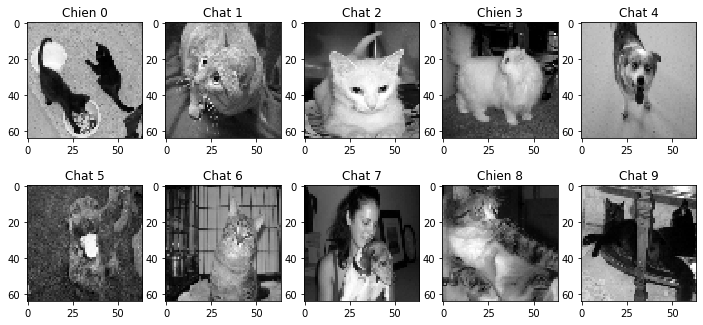

In [46]:
def afficherPhoto(X,y,nb_image,lig=2,col=5):
    '''Affiche les photos X avec le label y'''
    fig, axs = plt.subplots(lig,col) 
    fig.set_figheight(5.5)
    fig.set_figwidth(12)
    nb_image=0
    for i in range(lig):
        for j in range(col):
            axs[i,j].imshow(X[nb_image],cmap='gray')
            axs[i,j].set_title(f'Chat {nb_image}' if int(ya[nb_image][0])==0 else f'Chien {nb_image}')
            nb_image+=1
    plt.show()

def comparerPhoto(X1,X2,y,nb_image,lig=2,col=5):
    '''Affiche les photos X1 puis X2 avec le label y'''
    fig, axs = plt.subplots(2*lig,col) 
    fig.set_figheight(12)
    fig.set_figwidth(12)
    nb_image=0
    for i in range(lig):
        for j in range(col):
            axs[2*i,j].imshow(X1[nb_image],cmap='gray')
            axs[2*i+1,j].imshow(X2[nb_image],cmap='gray')
            axs[2*i,j].set_title(f'Chat {nb_image}' if int(ya[nb_image][0])==0 else f'Chien {nb_image}')
            nb_image+=1
    plt.show()
    
afficherPhoto(images,ya,10,2,5)

### Applatissement des images

In [11]:
print("Avant:")
print(Xa.shape)
print(Xt.shape)
Xa=Xa.reshape(Xa.shape[0],Xa.shape[1]*Xa.shape[2])
Xt=Xt.reshape(Xt.shape[0],Xt.shape[1]*Xt.shape[2])
ya=ya
yt=yt
print("Après:")
print(Xa.shape)
print(Xt.shape)

Avant:
(1000, 64, 64)
(200, 64, 64)
Après:
(1000, 4096)
(200, 4096)


### Normalisation des données

In [47]:
def normalize(Xa,Xt): 
    return Xa/255,Xt/255

def load_reshape():
    '''Load les données reshapes'''
    Xa, ya, Xt, yt = load_data()
    Xa=Xa.reshape(Xa.shape[0],Xa.shape[1]*Xa.shape[2])
    Xt=Xt.reshape(Xt.shape[0],Xt.shape[1]*Xt.shape[2])
    return Xa,ya,Xt,yt

Xa,ya,Xt,yt=load_reshape()
Xa,Xt=normalize(Xa,Xt)
print(Xa.shape,Xt.shape)
print(ya.shape,yt.shape)
print(Xa.max(),Xa.min())


(1000, 4096) (200, 4096)
(1000, 1) (200, 1)
0.996078431372549 0.0


### Perceptron : un neurone

In [13]:
random_state=1 #le modifier implique modifier les hyper-paramètres

##### Minimisation de l'erreur quadratique moyenne (MSE)
      

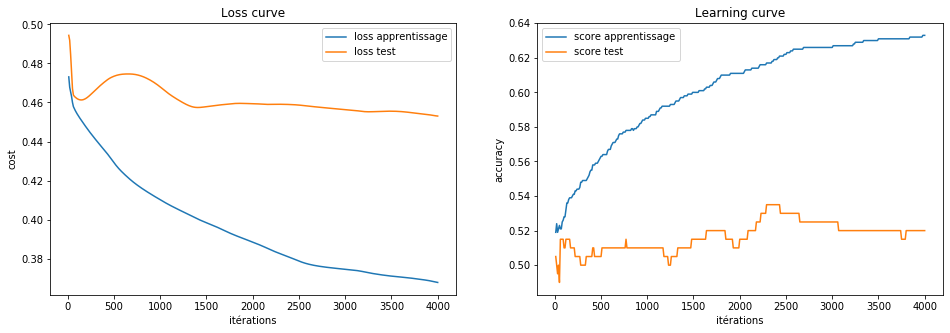

In [14]:
W,B,I,c_A,c_t,s_A,s_t=fit_memorise(Xa,ya,Xt,yt,[],'logistic','MSE',0.2,4000,random_state)
show_learning(I,c_A,c_t,s_A,s_t)

#####    Maximisation de la vraisemblance -> minimisation du coût : log_loss

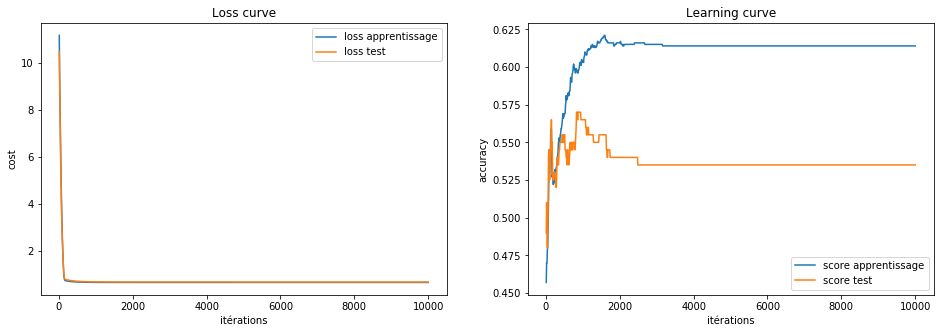

In [38]:
W,B,I,c_A,c_t,s_A,s_t=fit_memorise(Xa,ya,Xt,yt,[],'logistic','log_loss',0.01,10000,random_state)
show_learning(I,c_A,c_t,s_A,s_t)

<div class="alert alert-block alert-info">
On remarque que notre courbe de de coüt continue de descendre et celle de notre score d'apprentissage de monter mais les courbes de test n'évoluent pas : <b>Overfitting</b></div>

<div class="alert alert-block alert-danger">
Problèmes:
    
- On n'a pas assez de données pour le nombre de caractéristiques (Fléau de la dimension)
    
- Modèle trop simple : 1 neurone et 0 couche cachée</div>

<div class="alert alert-block alert-success">
Solutions:

- Il faut augmenter le nombre de données.

- Il faut réduire le nombre de variables : <b>Analyse en composantes principales</b>

- Augmenter le nombre de neurones pour obtenir un réseau de neurones multicouche : <b>MLP</b></div>

# C) Réduction du nombre de variables par analyse en composantes principales  <a class="anchor" id="chapter3"></a>

In [16]:
Xa,ya,Xt,yt=load_reshape()
X=np.concatenate((Xa,Xt),axis=0)
y=np.concatenate((ya,yt),axis=0)
print(X.shape)
print(y.shape)

(1200, 4096)
(1200, 1)


<div class="alert alert-block alert-info">
On n'utilise pas les étiquettes, on peut donc réduire sur toutes nos données, apprentissage et test .</div>

###  1) Standardiser les données

In [17]:
def standard(X):
    return (X-np.mean(X,axis=0))/np.std(X,axis=0) #axe des variables sont les colonnes
print("Avant :")
print("mean :",np.mean(X))
print("std :",np.std(X))
print("-----")
X=standard(X)
print("Après :")
print("mean :",np.mean(X))
print("std :",np.std(X))

Avant :
mean : 117.58331827799479
std : 64.36137764982327
-----
Après :
mean : 7.170190367370803e-19
std : 1.0000000000000004


### 2) Determiner la matrice de corrélation 

In [18]:
def correlation(X):
    precision=15
    C=np.round(np.corrcoef(X.T),precision)
    #On verifie que la matrice est bien symétrique sinon on baisse la précision
    while not np.array_equal(C,C.T):
        precision-=1
        C=np.round(np.corrcoef(X.T),precision)
    return C
C=correlation(X)
print(C.shape)
print(C[10:,10:])

(4096, 4096)
[[1.         0.91852933 0.88704884 ... 0.29364197 0.28979223 0.30365888]
 [0.91852933 1.         0.92147301 ... 0.29158158 0.28891645 0.29637601]
 [0.88704884 0.92147301 1.         ... 0.28033896 0.27625936 0.29054997]
 ...
 [0.29364197 0.29158158 0.28033896 ... 1.         0.95262059 0.91749956]
 [0.28979223 0.28891645 0.27625936 ... 0.95262059 1.         0.93825321]
 [0.30365888 0.29637601 0.29054997 ... 0.91749956 0.93825321 1.        ]]


### 3) Trouver les valeurs propres et les vecteurs propres de la matrice symétrique

In [19]:
eigen_values,P = np.linalg.eig(C)
print(eigen_values.size,P.shape)

4096 (4096, 4096)


### 4) Classer les valeurs propres par ordre décroissante 

### 5) Analyse
#### Inerties et eboulies

In [20]:
def inertie(k,eigen_values):
    total=np.sum(eigen_values)
    return np.sum(eigen_values[:k])/total

def les_inerties(k,eigen_values):
    the_range_inertie=list(range(k+1))
    return the_range_inertie,[ inertie(k,eigen_values) for k in the_range_inertie]

def les_eboulies(k,eigen_values):
    the_range_eboulie=list(range(1,k+1))
    return the_range_eboulie,[ eigen_values[k-1] for k in the_range_eboulie]

#### Visualisation

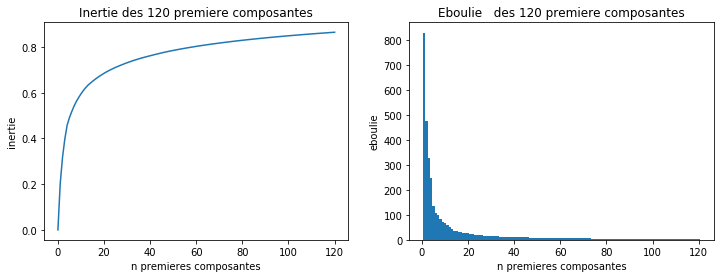

In [21]:
def show_inertie_eboulie(n_first_components,eigen_values):
    #calculs
    the_range_inertie,inertie=les_inerties(n_first_components,eigen_values)
    the_range_eboulie,eboulie=les_eboulies(n_first_components,eigen_values)
    #affichages
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(4)
    fig.set_figwidth(12)
    axs[0].plot(the_range_inertie,inertie)
    axs[0].set_xlabel('n premieres composantes')
    axs[0].set_ylabel('inertie')
    axs[0].set_title(f'Inertie des {n_first_components} premiere composantes')
    axs[1].bar(the_range_eboulie,eboulie,1)
    axs[1].set_xlabel('n premieres composantes')
    axs[1].set_ylabel('eboulie')
    axs[1].set_title(f'Eboulie   des {n_first_components} premiere composantes')

show_inertie_eboulie(120,eigen_values)



### 6) Conserver les k premiers vecteurs selon l'inertie souhaitée

In [22]:
k=100
print(f'Pour k = {k}, l\'inertie est de : {round(inertie(k,eigen_values),2)}')
new_P=P[:,:k]

Pour k = 100, l'inertie est de : 0.85


<div class="alert alert-block alert-info">
Essayons de réduire à <b>100</b> variables avec une inertie proche de 85% </div>

### 7) Projection des nos données par la matrice de passage 

$$
\begin{alignat}{5}
 X_{new} =& {}^T({}^TP.{}^TX) \\
 =& {}^T({}^T(XP))\\
 =& X.P\\
 \newline
 X_{old} =& X.P.P^{-1}\\
 =& X_{new}.P^{-1}\\
 =& X_{new}.{}^TP\\
\end{alignat}
$$

In [23]:
print(f'Notre de matrice de passage possède une shape : {P.shape}')
print(f'Notre X possède une shape : {X.shape}')
print('----')
#On s'adapte aux shapes
new_X=np.dot(new_P.T,X.T).T
print(f'Notre nouveau X possède une shape : {new_X.shape}')

def transform(X,P,k):
    '''Retourne le nouveau et l'ancien X selon la matrice de passage et k le nombre de composantes'''
    new_P=P[:,:k]
    new_X=np.dot(new_P.T,X.T).T
    P_inv=P.T[:new_X.shape[1],:]
    old_X=np.dot(new_X,P_inv)
    return new_X,old_X


Notre de matrice de passage possède une shape : (4096, 4096)
Notre X possède une shape : (1200, 4096)
----
Notre nouveau X possède une shape : (1200, 100)


### 8) Visualisation 
#### Les photos modifiées / Ce que voit l'IA

In [24]:
#calcul de l'inverse de la matrice de passage originale: ie la transposée
#on récupères les k premieres LIGNES 
P_inv=P.T[:new_X.shape[1],:]
print(f'Notre matrice de passage inverse possède une shape : {P_inv.shape}')
old_X=np.dot(new_X,P_inv)
print(f'Notre ancien X  possède une shape : {old_X.shape}')
new_images=old_X.reshape(1200,64,64)
print(f'Nos nouvelles images possèdent une shape : {new_images.shape}')

Notre matrice de passage inverse possède une shape : (100, 4096)
Notre ancien X  possède une shape : (1200, 4096)
Nos nouvelles images possèdent une shape : (1200, 64, 64)


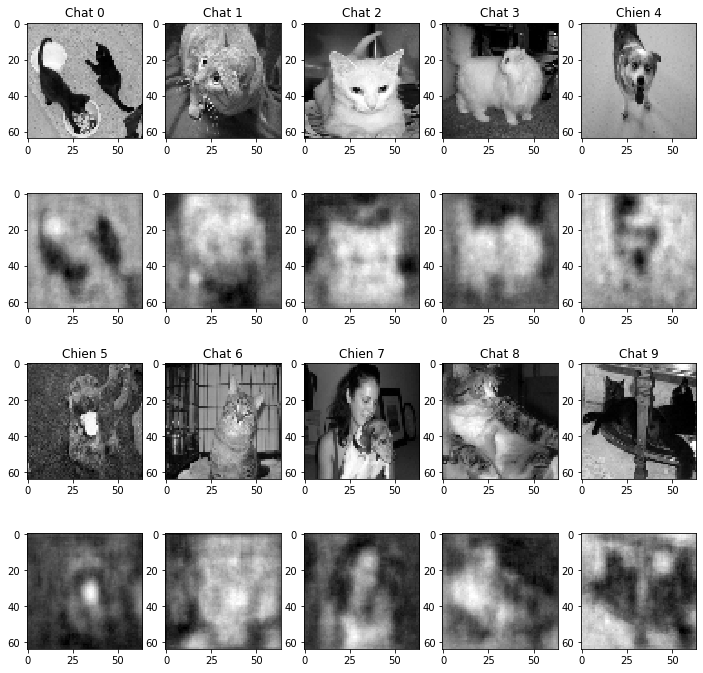

In [25]:
k=100
new_X,old_X=transform(X,P,k)
new_images=old_X.reshape(1200,64,64)
comparerPhoto(images,new_images,ya,10,2,5)

<div class="alert alert-block alert-success">
Le résultat semble être satisfaisant, on reconnait la forme des photos avec seulement 100 variables.</div>

#### L'hyperplan

Il va être difficile des les départager avec seulement deux composantes


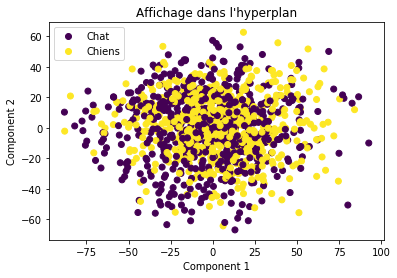

In [26]:
new_P_2=P[:,:2]
new_X_2=np.dot(new_P_2.T,X.T).T
s=plt.scatter(new_X[:,0],new_X[:,1],c=y[:,0])
plt.title("Affichage dans l'hyperplan")
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(handles=s.legend_elements()[0], labels=['Chat','Chiens'])
print("Il va être difficile des les départager avec seulement deux composantes")

In [27]:
Xa,Xt,ya,yt = train_test_split(new_X,y,test_size=0.166,shuffle=True,random_state=42)
print(Xa.shape,ya.shape)
print(Xt.shape,yt.shape)

(1000, 100) (1000, 1)
(200, 100) (200, 1)


# D) Test des données reduites avec un MLP  <a class="anchor" id="chapter4"></a>

### Optimisation des hyper-paramètres avec scikit-learn

In [28]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

#On reforme les données standardisées
#Xa, ya, Xt, yt = load_reshape() 
#X=np.concatenate((Xa,Xt),axis=0)
#y=np.concatenate((ya,yt),axis=0).reshape(X.shape[0])
#X=StandardScaler().fit_transform(X)

#on essaye d'optimisiser pca -> mlp en utilisant Pipeline de sklearn 
mlp=MLPClassifier(max_iter=500)
pca=PCA()
pipeline=Pipeline(steps=[('pca',pca),('mlp',mlp)])

#choix des espaces des hyperparamètres
n_components= [20,40,60,80,100]
hidden_layer_sizes=[ couche*(i+1) for i in range(4) for couche in [ (16,),(32,),(64,),(128,)]]

parameter_space = dict(
    pca__n_components=n_components,
    mlp__hidden_layer_sizes= hidden_layer_sizes,
    mlp__activation= ['logistic','relu'],
    mlp__solver= ['adam','sgd'],
    mlp__alpha= [0.001,0.01,0.1])

#on entraine via une grille de recherche par cross validation
clf = GridSearchCV(pipeline, parameter_space, n_jobs=-1, cv=10)
#clf.fit(X,y)
#results=pd.DataFrame(clf.cv_results_)
#results.to_csv('results_GridSearch.csv')

In [29]:
results=pd.read_csv('results_GridSearch.csv').sort_values(by=['rank_test_score'])

In [30]:
results.head(20)  #premier logistic : 20 components , (128,) ,solver=sgd ,alpha=0.1    -> classé 31

,activation,alpha,hidden_layer_sizes,solver,n_components,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
490,relu,0.001,"(32,)",adam,20,0.683333,0.641667,0.550000,0.575000,0.550000,0.550000,0.625000,0.666667,0.591667,0.675000,0.610833,0.051377,1
806,relu,0.100,"(16,)",sgd,40,0.533333,0.641667,0.575000,0.616667,0.575000,0.508333,0.608333,0.650000,0.625000,0.675000,0.600833,0.049924,2
715,relu,0.010,"(128, 128)",sgd,20,0.608333,0.641667,0.591667,0.583333,0.558333,0.525000,0.600000,0.675000,0.575000,0.650000,0.600833,0.042728,2
958,relu,0.100,"(128, 128, 128, 128)",sgd,80,0.633333,0.600000,0.616667,0.541667,0.625000,0.558333,0.616667,0.616667,0.616667,0.566667,0.599167,0.030150,4
954,relu,0.100,"(128, 128, 128, 128)",adam,100,0.591667,0.600000,0.566667,0.616667,0.608333,0.616667,0.600000,0.566667,0.633333,0.583333,0.598333,0.020683,5
553,relu,0.001,"(128, 128)",adam,80,0.608333,0.616667,0.558333,0.608333,0.616667,0.500000,0.658333,0.591667,0.575000,0.650000,0.598333,0.043589,5
753,relu,0.010,"(128, 128, 128)",adam,80,0.541667,0.616667,0.566667,0.550000,0.616667,0.533333,0.608333,0.625000,0.666667,0.641667,0.596667,0.043333,7
713,relu,0.010,"(128, 128)",adam,80,0.591667,0.658333,0.591667,0.566667,0.600000,0.566667,0.641667,0.575000,0.575000,0.600000,0.596667,0.029392,7
700,relu,0.010,"(64, 64)",adam,20,0.600000,0.658333,0.608333,0.575000,0.566667,0.550000,0.575000,0.650000,0.566667,0.616667,0.596667,0.034801,7
585,relu,0.001,"(64, 64, 64)",sgd,20,0.591667,0.616667,0.575000,0.591667,0.550000,0.508333,0.650000,0.625000,0.608333,0.650000,0.596667,0.041866,7


### Interprétation des résultats

 * <b>Activations</b> : On remarque que la fonction <b>Relu</b> est plus efficace, néanmois sur près de <b>1000</b> différents modèles, avec une cross-validation de <b>10</b> epochs pour éviter la variance : seuls <b>3</b> ont dépassé un score de 0.6 malgrès une variance élevée.
 
 
 * <b>Nombre de composantes</b> : On constate que le nombre de composantes n'influence pas l'apprentissage : varier entre 20 qui a une inertie de 
    <b>0.64</b> et 100 de <b>0.85</b> n'a pas un réel impact (peut être du au fait que les scores sont faibles).
    
 
 * <b>Learning_rate</b> : Les résultats suggèrent que le learning_rate dépend du <b>nombre de couches</b>, de l'<b>activation</b> et du <b>solver</b>.
 
 
 * <b>Hidden_layer_size</b> : Le <b>nombre de couches et de neurones</b>, restent encore très difficile à interpreter. On remarque que les deux meilleurs modèles n'ont qu'une couche et peu de neurones. Néanmoins dans le <b>top 20</b> : 128x128x128x128 semble être efficace.
    
    
    

<div class="alert alert-block alert-success">
Essayons de reproduire quelques modèles du <b>top 20 </b>.</div>

### Tests de modèles sur 20 composantes

In [31]:
k=20
new_X,old_X=transform(X,P,k)
random_state=65 #le modifier implique modifier les hyper-paramètres
Xa,Xt,ya,yt = train_test_split(new_X,y,test_size=0.166,shuffle=True,random_state=random_state)
print(Xa.shape,Xt.shape)

(1000, 20) (200, 20)


   ###### Relu, 32  : classé 1

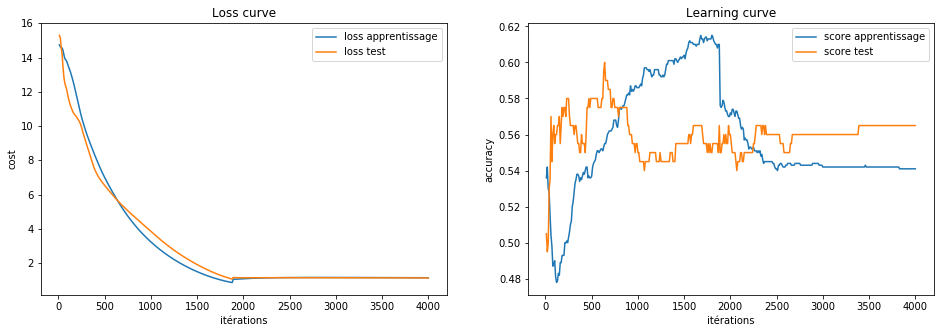

In [32]:
W,B,I,c_A,c_t,s_A,s_t=fit_memorise(Xa,ya,Xt,yt,[32],'relu','log_loss',0.001,4000,random_state=random_state)
show_learning(I,c_A,c_t,s_A,s_t)

In [33]:
mlp=MLPClassifier(max_iter=2000,hidden_layer_sizes=(32,),solver='adam',alpha=0.001)
cross_score=cross_val_score(mlp, new_X,y, cv=20)
print(cross_score)
print("Mean_score : ",cross_score.mean())

[0.6        0.56666667 0.56666667 0.5        0.51666667 0.65
 0.66666667 0.6        0.46666667 0.63333333 0.46666667 0.48333333
 0.63333333 0.61666667 0.58333333 0.65       0.5        0.55
 0.66666667 0.53333333]
Mean_score :  0.5725


###### Relu, 128x128 classé 3

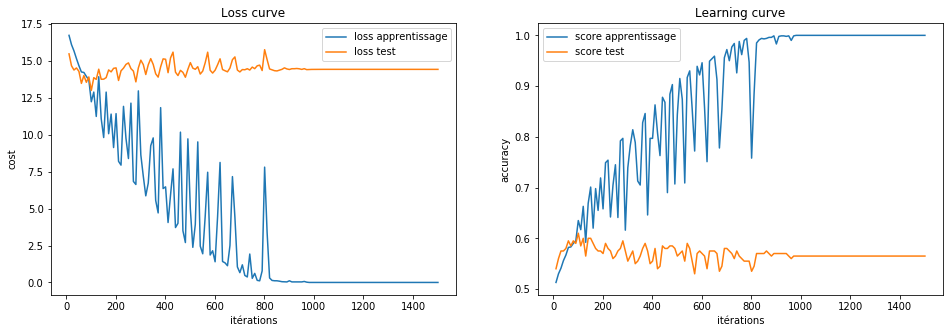

In [34]:
W,B,I,c_A,c_t,s_A,s_t=fit_memorise(Xa,ya,Xt,yt,[128,128],'relu','log_loss',0.001,1500,random_state=random_state)
show_learning(I,c_A,c_t,s_A,s_t)

In [35]:
mlp=MLPClassifier(max_iter=2000,hidden_layer_sizes=(128,128,),solver='sgd',alpha=0.01)
cross_score=cross_val_score(mlp, new_X,y, cv=10)
print(cross_score)
print("Mean_score : ",cross_score.mean())

[0.5        0.575      0.55833333 0.55       0.5        0.6
 0.63333333 0.60833333 0.55       0.69166667]
Mean_score :  0.5766666666666667


#### Logistic ,128 , classé 31

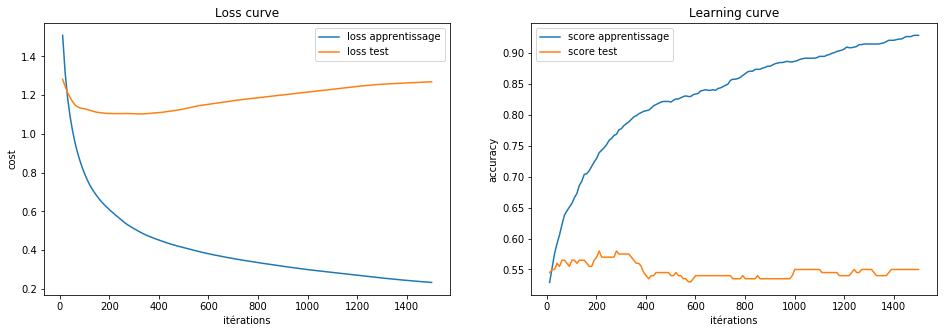

In [36]:
#premier logistic : 20 components , (128,) ,solver=sgd ,alpha=0.1    -> classé 31
W,B,I,c_A,c_t,s_A,s_t=fit_memorise(Xa,ya,Xt,yt,[128],'logistic','log_loss',0.1,1500,random_state=random_state)
show_learning(I,c_A,c_t,s_A,s_t)

In [37]:
mlp=MLPClassifier(max_iter=2000,hidden_layer_sizes=(128,),activation='logistic',solver='sgd',alpha=0.01)
cross_score=cross_val_score(mlp, new_X,y, cv=10)
print(cross_score)
print("Mean_score : ",cross_score.mean())

[0.5        0.49166667 0.56666667 0.525      0.55       0.55833333
 0.575      0.61666667 0.61666667 0.55      ]
Mean_score :  0.5549999999999999


# Conclusion <a class="anchor" id="chapter5"></a>

* Le projet nous à permis de comprendre l'enjeu de la <b>propagation avant et arrière</b> dans un réseau de neurones, et l'impacts du choix de nos <b>hyper-paramètres</b>.

* Le projet nous à permis de comprendre l'importance de la <b>normalisation</b> et de la <b>réduction du nombre de variables</b>  par <b>ACP</b> pour une classification de photos.

* Néanmois, on constate qu'un <b>MLP</b> n'est pas le meilleur modèle pour une classification de photos, on pourrait s'interesser à des réseaux plus complexes tels que <a href="https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif" target="_blank" >les réseaux neuronaux convolutifs</a>.